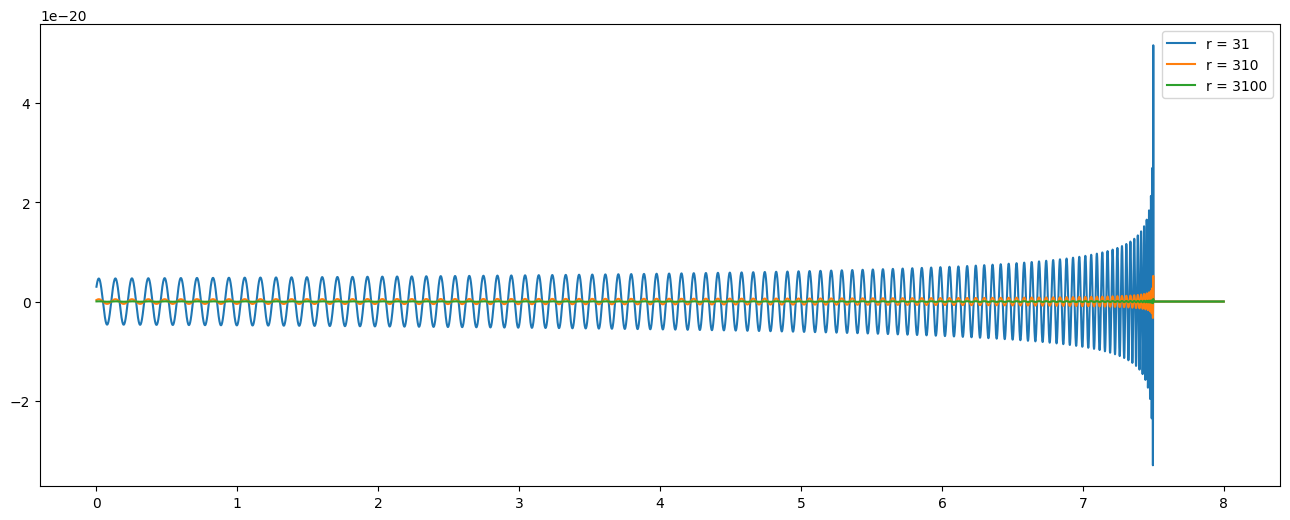

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const


G = const.G # 万有引力常数, m^3 kg^-1 s^-2
c = const.c  # 光速, m/s
msun = 1.989e30  # 太阳质量, kg
pc = 3.086e16  # pc到m的转换
m1 = 40  # 第一个黑洞质量（太阳质量）
m2 = 30  # 第二个黑洞质量（太阳质量）
# M_chirp = (m1 * m2 / (m1 + m2) ** 2) ** (3/5) * (m1 + m2)  # 啁啾质量
M_chirp = (m1 * m2) ** (3 / 5) / (m1 + m2) ** (1 / 5)
M_chirp = M_chirp * msun  # 转换为kg

# 透镜参数
mlz = 5e4 * msun  # 透镜质量
y = 0.5  # 影响参数

# 采样参数 - 与LIGO一致
fs = 4096  # 采样率调整为LIGO的标准采样率
dt = 1 / fs
t = np.arange(0, 8, dt)  # 时间范围调整，使其更加聚焦于合并前的最后阶段
t_len = t[-1] - t[0]
N = len(t)

# 引力波参数 - 调整以匹配GW150914
tc = 7.5  # 合并时间，选择使信号在最后时刻达到峰值
phi_c = 0.25 * np.pi


def generate_unlensed_gw(dataX, r, m_c, tc, phi_c):

    r = r * 1e6 * pc  # 距离（米）
    # 生成引力波信号
    t = dataX  # 时间序列

    # 在合并前的有效区域计算信号
    valid_idx = t < tc
    t_valid = t[valid_idx]

    # 初始化波形
    h = np.zeros_like(t)

    if np.sum(valid_idx) > 0:  # 确保有有效区域
        # 计算频率演化参数 Theta
        Theta = c ** 3 * (tc - t_valid) / (5 * G * m_c)

        # 计算振幅
        A_gw = (G * m_c / (c ** 2 * r)) * Theta ** (-1 / 4)

        # 计算相位
        phase = 2 * phi_c - 2 * Theta ** (5 / 8)

        # 生成波形
        h[valid_idx] = A_gw * np.cos(phase)

    return h

r1 = 31 
r2 = 310 
r3 = 3100 

h1 = generate_unlensed_gw(t, r1, M_chirp, tc,phi_c)
h2 = generate_unlensed_gw(t, r2, M_chirp, tc,phi_c)
h3 = generate_unlensed_gw(t, r3, M_chirp, tc,phi_c)


fig = plt.figure(figsize=(16, 6))
plt.plot(t,h1,label = 'r = 31')
plt.plot(t,h2,label = 'r = 310')
plt.plot(t,h3,label = 'r = 3100')
plt.legend()
plt.show()

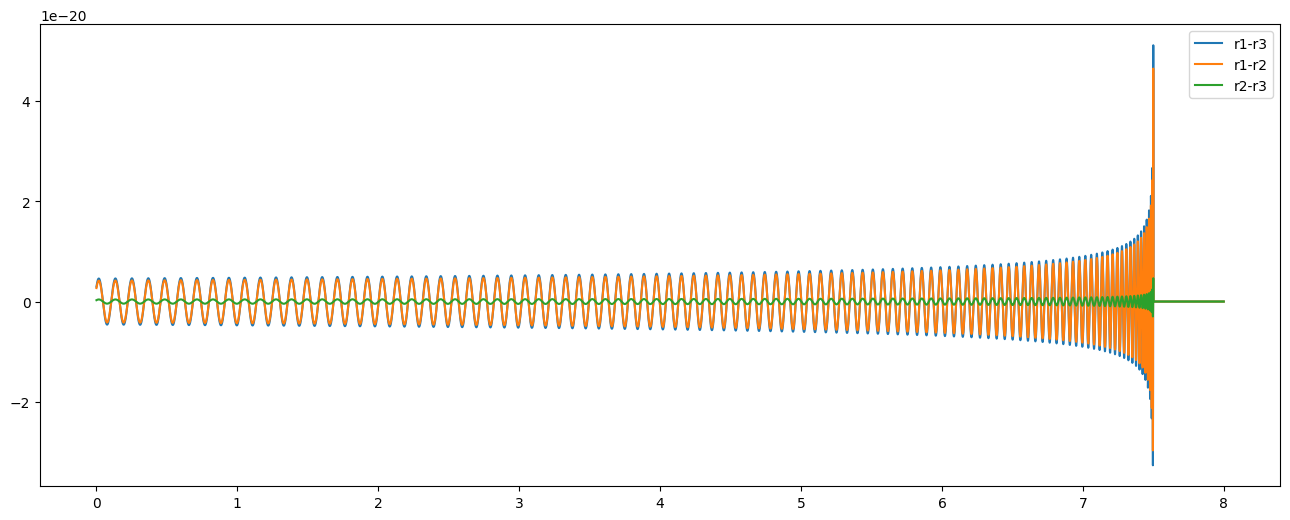

In [36]:
fig = plt.figure(figsize=(16, 6))
plt.plot(t,h1-h3,label = 'r1-r3')
plt.plot(t,h1-h2,label = 'r1-r2')
plt.plot(t,h2-h3,label = 'r2-r3')
plt.legend()
plt.show()

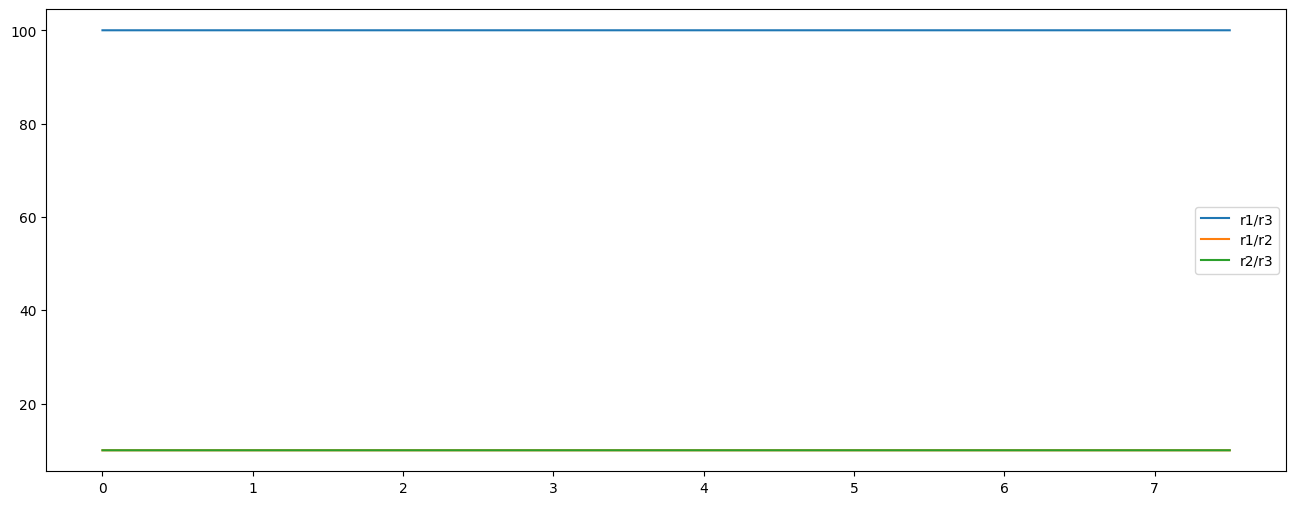

In [37]:
fig = plt.figure(figsize=(16, 6))
print()
plt.plot(t[t<7.5],h1[t<7.5]/h3[t<7.5],label = 'r1/r3')
plt.plot(t[t<7.5],h1[t<7.5]/h2[t<7.5],label = 'r1/r2')
plt.plot(t[t<7.5],h2[t<7.5]/h3[t<7.5],label = 'r2/r3')
plt.legend()
plt.show()

In [38]:
print("h1/h2 = ",(h1[t<7.5]/h2[t<7.5]))
print("h1/h3 = ",(h1[t<7.5]/h3[t<7.5]))
print("h2/h3 = ",(h2[t<7.5]/h3[t<7.5]))

h1/h2 =  [10. 10. 10. ... 10. 10. 10.]
h1/h3 =  [100. 100. 100. ... 100. 100. 100.]
h2/h3 =  [10. 10. 10. ... 10. 10. 10.]


PSO的参数

In [52]:
from scipy.interpolate import interp1d
import scipy.io as scio
r_pso = 4065.3585193806894
m_c_pso = 30.101478668419787 * msun
t_c_pso = 7.49998099453617
phi_c_pso = 0.3730915647894762 * np.pi
I = 0.28654044328641365
td = 0.824987694293145
h_pso = generate_unlensed_gw(t, r_pso, m_c_pso, t_c_pso, phi_c_pso)
## 函数：透镜放大因子（时域方法2）
def lens_time(h_original, t, y):
    # 计算放大因子
    mu_plus = np.sqrt(1 + 1 / y)  # 主像
    mu_minus = np.sqrt(-1 + 1 / y) if y < 1 else 0  # 次像

    # 计算物理时间延迟
    td = 8 * y * mlz * G /(c ** 3) # 秒
    # 创建插值函数
    interp_func = interp1d(t, h_original, kind='cubic', bounds_error=False, fill_value=0)
    # 创建延迟时间点
    t_delayed = t + td

    # 计算延迟信号
    h_delayed = interp_func(t_delayed)

    # 透镜化效应：原始信号和延迟信号的组合
    h_lensed = mu_plus * h_original

    # 只有在y<1时才有次像
    if y < 1:
        h_lensed = h_lensed - mu_minus * h_delayed  # 次像有π相位差(负号)
    return h_lensed
h_lens_pso = lens_time(h_pso, t, 0.554556648752591)

dataY = scio.loadmat('data.mat')
noise_get = scio.loadmat('noise.mat')

data = dataY['data'][0]
noise = noise_get['noise'][0]
signal = data - noise

In [53]:
r_mcmc = 0.20797666049935495
m_c_mcmc = 30.13238918308725 * msun
t_c_mcmc = 7.499965324352041
phi_c_mcmc = 0.12458503629239366 * np.pi
I_mcmc = 0.14534162620013696
td_mcmc = 0.995227375675629
h_mcmc = generate_unlensed_gw(t, r_mcmc, m_c_mcmc, t_c_mcmc, phi_c_pso)
h_lens_mcmc = lens_time(h_mcmc, t, 0.7462038873373837)

/tmp/ipykernel_44140/433483210.py:2: RuntimeWarning: invalid value encountered in divide
  plt.plot(t,h_lens_pso / signal,label = 'pso/signal')
/tmp/ipykernel_44140/433483210.py:3: RuntimeWarning: invalid value encountered in divide
  plt.plot(t,h_lens_mcmc / signal,label = 'mcmc/signal')


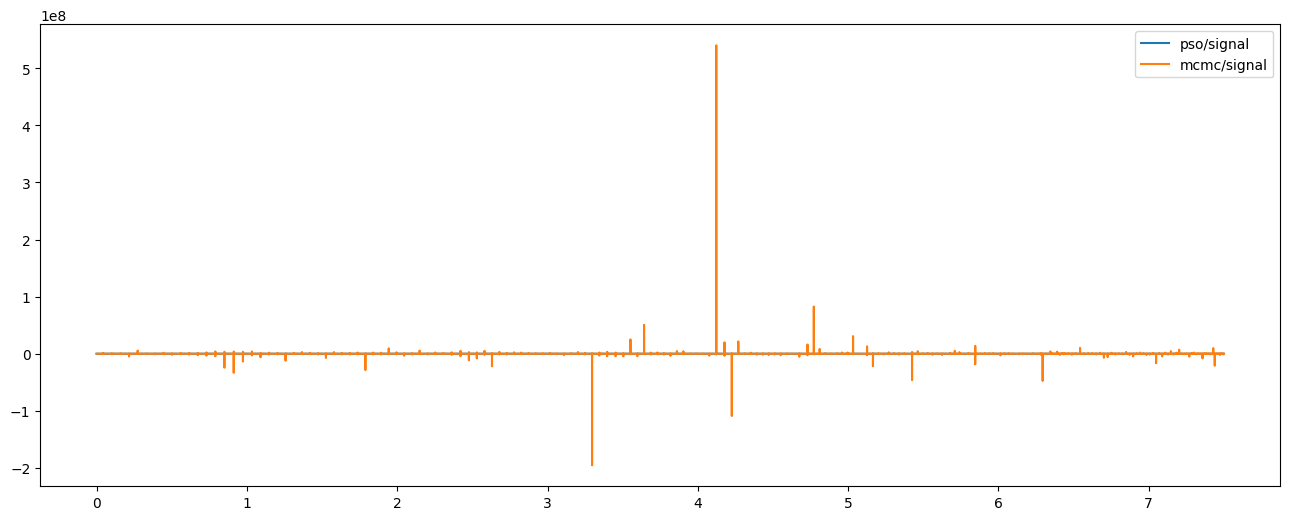

In [54]:
fig = plt.figure(figsize=(16, 6))
plt.plot(t,h_lens_pso / signal,label = 'pso/signal')
plt.plot(t,h_lens_mcmc / signal,label = 'mcmc/signal')
plt.legend()
plt.show()

In [55]:
Ipso=0.28654044328641365
ypso = (1-Ipso)/(Ipso +1)
Imcmc = 0.14534162620013696
ymcmc = (1-Imcmc)/(Imcmc +1)

print("PSO=", ypso,"MCMC=",ymcmc)

PSO= 0.554556648752591 MCMC= 0.7462038873373837


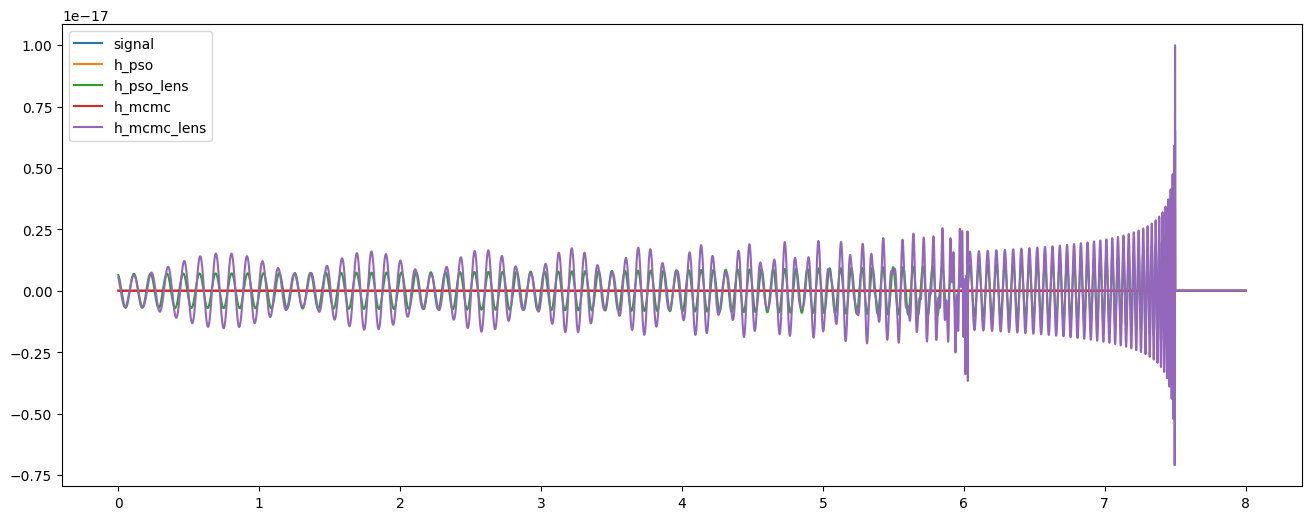

In [51]:
fig = plt.figure(figsize=(16, 6))
plt.plot(t,signal,label = 'signal')
plt.plot(t,h_pso,label = 'h_pso')
plt.plot(t,h_mcmc,label = 'h_pso_lens')
plt.plot(t,h_lens_pso,label = 'h_mcmc')
plt.plot(t,h_lens_mcmc,label = 'h_mcmc_lens')
plt.legend()
plt.show()

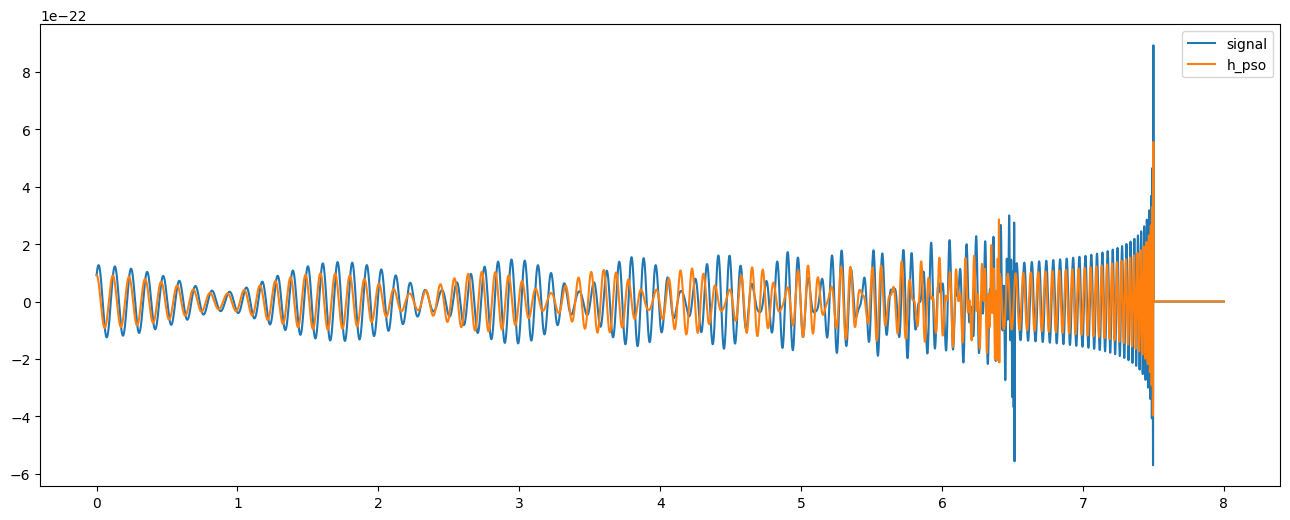

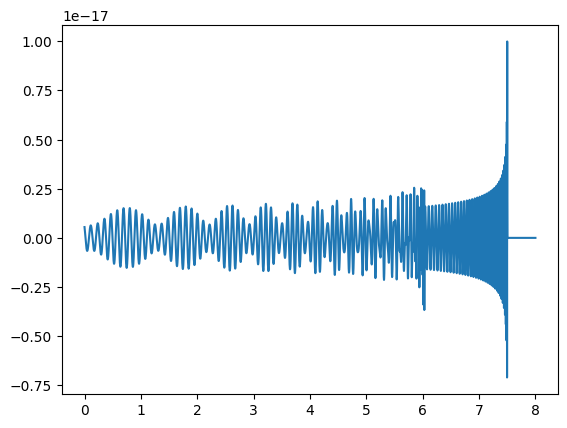

In [61]:
fig = plt.figure(figsize=(16, 6))
plt.plot(t,signal,label = 'signal')
plt.plot(t,h_lens_pso,label = 'h_pso')
plt.legend()
plt.show()


plt.plot(t,h_lens_mcmc,label = 'h_mcmc')